## **Modelagem**


Especificamente esse notebook é destinado a uma anotação comentada do capítulo 3 do livro [Hands-On Machine Learning](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), que eu achei bem informativo e bom para praticar de forma geral.

A ideia desse capítulo é começar a falar mais de Modelos de Classificação, porém o que me entusiasmou é a ideia em cima de extrair mais informações sobre as métricas e como podemos escolhê-las a nosso favor. Tudo o que eu fiz aqui é por causa do livro, e se acharem interessante, deem uma olhada nele! Estou achando o conteúdo bem satisfatório e complementar com ideias anteriores de outros materiais que já estudei.

Porém primeiramente, só para dar uma ideia sobre o que se trata MNIST é um conjunto de 70000 imagens pequenas de algarismos escritos a mão por estudantes do ensino médio e funcionários do US Census Bureau.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']

Para ter uma ideia de como são as imagens vamos dar uma olhada em uma delas:

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

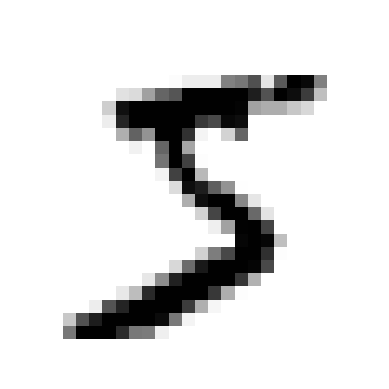

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

In [4]:
y[0]

'5'

In [6]:
import numpy as np
y = y.astype(np.uint8)

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, 
               interpolation='nearest')
    plt.axis("off")

No livro ele trás mais exemplos de visualizações dos números, porém vamos nos reter ao 5. O conjunto é bem balanceados, e já é formatado para ter os últimos 10000 elementos como conjunto de teste, então vamos fazer a separação.

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 

Antes de partir para um modelo de classificação multiclasse, vamos para uma classificação binária, onde podemos já ter uma ideia geral de como é feito o processo em um modelo de classificação e dar uma olhada nas métricas de desempenho.

## Classificação Binária

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

O modelo que será utilizado é o SGDClassifier, ele é bom para grandes conjuntos de dados, onde pelo o que eu entendi, ele trabalha de exemplo a exemplo e vai melhorando os parâmetros que são utilizados para definir a classe.

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, 
                        tol=1e-3, 
                        random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Os hiperparâmetros são só definidos para manter fixo os resultados, e não ter problemas com possíveis alterações no futuro.

In [13]:
sgd_clf.predict([some_digit])

array([ True])

Isso significa que aquele 5 que mostramos mais cedo, conseguimos predizer com o SGDClassifier!

Vamos um pouco mais longe, e ver o score da validação cruzada desse modelo, vamos pela accuracy mesmo.

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Uma medidade de 96% de acurácia pode parecer bom a princípio porém, ela é enganosa em datasets desbalanceados, que nesse caso é desbalanceado a quantidade de números 5 em relação ao resto.

Vamos um pouco mais longe ainda e começar a olhar para outroas medidas de performance!

### Métricas de desempenho

Forma alternativa de calcular o desempenho de acurácia com Validação Cruzada. Somente dentro do conjunto de treinamento, fazendo a estratificação k-fold no conjunto de treino.

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    

0.9669
0.91625
0.96785


Novamente, valores muito altos, vamos tentar olhar por outro lado agora:
Vamos criar um estimador que sempre retornará Falso! Ou seja ele nunca irá prever um 5.

In [16]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring= 'accuracy')

array([0.91125, 0.90855, 0.90915])

Olha só! Mesmo só classificando como não-5, ele continuou com uma acurácia de 91%! Isso mostra que em situações que o dataset esteja desbalanceado, a acurácia não é uma boa métrica de desempenho, pois ela nos engana dando a ideia de que o modelo está indo bem porém, em nenhum momento ele de fato acerto um 5. Bem complicado essa situação.

Vamos abrir os horizontes, chega de acurácia e vamos para a **Matriz confusão**!

### Matriz Confusão

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_pred, y_train_5)

array([[53892,  1891],
       [  687,  3530]])

**O que é esse array?**

Esse é a demonstração das 4 possibilidades segundo a seguinte imagem:

![matriz](./images/matrizConfusao.png)

Porém, pelo sklearn, as ordens dos 'Sim' e 'Não' são trocados, então vamos explicar a representação:
* Verdadeiro Positivo (Segunda linha, segunda coluna): 3530 são predições corretas em relação ao número 5.
* Falso Positivo (Primeira linha, segunda coluna): 1891 são predições que estavam prevendo como positivo porém na realidade eram negativo.
* Falso Negativo (Segunda linha, primeira coluna): 687 são predições que estavam prevendo como negativo porém na realidade eram positivo.
* Verdadeiro Negativo (Primeira linha, primeira coluna): 53892 são predições corretas em relação ao número não ser 5.

E através dessa informações podemos extrair mais detalhes de como o modelos está acertando suas previsões e as instâncias do treino separadamente e tirar melhores conclusões sobre como está a previsão do modelo como um todo.

---

No melhor caso possível é quando não temos mais erros de falso negativo e falso positivo. Como o caso abaixo:

In [21]:
y_train_perfect_predicitions = y_train_5 # Pretenda que chegamos a perfeição
confusion_matrix(y_train_5, y_train_perfect_predicitions)

array([[54579,     0],
       [    0,  5421]])

### Precisão e Sensibilidade(Recall)
Da matriz de confusão, podemos tirar as métricas interessantes de precisão e sensibilidade, que trarei mais detalhes na próxima atualização.